# Part 1: `tweetharvest` Example Analysis

This is an example notebook demonstrating how to establish a connection to a database of tweets collected using [`tweetharvest`](https://github.com/ggData/tweetharvest). It presupposes that all [the setup instructions](https://github.com/ggData/tweetharvest/blob/master/README.md) have been completed (see README file for that repository) and that MongoDB server is running as described there. We start by importing core packages the [PyMongo package](http://api.mongodb.org/python/current/index.html), the official package to access MongoDB databases.

In [1]:
import pymongo

Next we establish a link with the database. We know that the database created by `tweetharvester` is called `tweets_db` and within it is a collection of tweets that goes by the name of the project, in this example: `emotweets`.

In [2]:
db = pymongo.MongoClient().tweets_db
coll = db.emotweets
coll

Collection(Database(MongoClient('localhost', 27017), u'tweets_db'), u'emotweets')

We now have an object, `coll`, that offers full access to the MongoDB API where we can analyse the data in the collected tweets. For instance, in our small example collection, we can count the number of tweets:

In [3]:
coll.count()

10598

Or we can count the number of tweets that are geolocated with a field containing the latitude and longitude of the user when they sent the tweet. We construct a MongoDB query that looks for a non-empty field called `coordinates`.

In [4]:
query = {'coordinates': {'$ne': None}}
coll.find(query).count()

607

Or how many tweets had the hashtag `#happy` in them?

In [5]:
query = {'hashtags': {'$in': ['happy']}}
coll.find(query).count()

8258

## Pre-requisites for Analysis

In order to perform these analyses there are a few things one needs to know:

1. At the risk of stating the obvious: how to code in [Python](http://www.python.org) (there is also [an excellent tutorial](https://docs.python.org/2/tutorial/)). Please note that the current version of `tweetharvest` uses Python 2.7, and not Python 3.
2. How to perform mongoDB queries, including aggregation, counting, grouping of subsets of data. There is a most effective short introduction ([The Little Book on MongoDB](http://openmymind.net/mongodb.pdf) by Karl Seguin), as well as [extremely rich documentation](http://docs.mongodb.org/manual/reference/) on the parent website.
3. [How to use PyMongo](http://api.mongodb.org/python/current/) to interface with the MongoDB API.

Apart from these skills, one needs to know how each status is stored in the database. Here is an easy way to look at the data structure of one tweet.

In [6]:
coll.find_one()

{u'_id': 610008194618757121L,
 u'contributors': None,
 u'coordinates': None,
 u'created_at': datetime.datetime(2015, 6, 14, 8, 57, 41),
 u'entities': {u'hashtags': [{u'indices': [0, 4], u'text': u'sad'}],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 2,
 u'favorited': False,
 u'geo': None,
 u'hashtags': [u'sad'],
 u'id_str': u'610008194618757121',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'und',
 u'metadata': {u'iso_language_code': u'und', u'result_type': u'recent'},
 u'place': None,
 u'retweet_count': 1,
 u'retweeted': False,
 u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 u'text': u'#sad',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': datetime.datetime(2012, 10, 26, 5, 15, 26),
  u'default_profile': F

This JSON data structure is [documented on the Twitter API website](https://dev.twitter.com/overview/api/tweets) where each field is described in detail. It is recommended that this description is studied in order to understand how to construct valid queries.

`tweetharvest` is faithful to the core structure of the tweets as described in that documentation, but with minor differences created for convenience:

1. All date fields are stored as MongoDB `Date` objects and returned as Python `datetime` objects. This makes it easier to work on date ranges, sort by date, and do other date and time related manipulation.
2. A `hashtags` field is created for convenience. This contains a simple array of all the hashtags contained in a particular tweet and can be queried directly instead of looking for tags inside a dictionary, inside a list of other entities. It is included for ease of querying but may be ignored if one prefers.

## Next Steps

This notebook establishes how you can connect to the database of tweets that you have harvested and how you can use the power of Python and MongoDB to access and analyse your collections. Good luck!

# Part 2: `tweetharvest` Further Analysis

Assuming we need some more advanced work to be done on the dataset we have collected, below are some sample analyses to dip our toes in the water.

The examples below are further illustration of using our dataset with standard Python modules used in datascience. The typical idion is that of queryiong MongoDB to get a cursor on our dataset, importing that into an analytic tool such as Pandas, and then producing the analysis. The analyses below require that a few packages are installed on our system:

- matplotlib: a python 2D plotting library  ([documentation](http://matplotlib.org/contents.html))
- pandas: "an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools" ([documentation](http://pandas.pydata.org/))

## Important Note

**The dataset used in this notebook is not published on the Github repository. If you want to experiment with your own data, you need to install the `tweetharvest` package, harvest some tweets to replicate the `emotweets` project embedded there, and then run the notebook. The intended use of this example notebook is simply as an illustration of the type of analysis one might want to do using your own tools.**

In [7]:
%matplotlib inline

In [8]:
import pymongo  # in case we have run Part 1 above
import pandas as pd  # for data manipulation and analysis

import matplotlib.pyplot as plt

/Users/gauden/anaconda/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/gauden/anaconda/lib/python2.7/argparse.pyc, but /Users/gauden/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


## Establish a Link to the Dataset as a MongoDB Collection

In [9]:
db = pymongo.MongoClient().tweets_db
COLL = db.emotweets
COLL

Collection(Database(MongoClient('localhost', 27017), u'tweets_db'), u'emotweets')

## Descriptive Statistics

### Number of Tweets in Dataset

In [10]:
COLL.count()

10598

In [11]:
def count_by_tag(coll, hashtag):
    query = {'hashtags': {'$in': [hashtag]}}
    count = coll.find(query).count()
    return count

print 'Number of #happy tweets: {}'.format(count_by_tag(COLL, 'happy'))
print 'Number of #sad tweets: {}'.format(count_by_tag(COLL, 'sad'))

Number of #happy tweets: 8258
Number of #sad tweets: 2403


### Number of Geolocated Tweets

In [12]:
query = {'coordinates': {'$ne': None}}
COLL.find(query).count()

607

### Range of Creation Times for Tweets

In [13]:
# return a cursor that iterates over all documents and returns the creation date
cursor = COLL.find({}, {'created_at': 1, '_id': 0})

# list all the creation times and convert to Pandas DataFrame
times = pd.DataFrame(list(cursor))
times = pd.to_datetime(times.created_at)

earliest_timestamp = min(times)
latest_timestamp = max(times)

print 'Creation time for EARLIEST tweet in dataset: {}'.format(earliest_timestamp)
print 'Creation time for LATEST tweet in dataset: {}'.format(latest_timestamp)

Creation time for EARLIEST tweet in dataset: 2015-06-13 07:24:40
Creation time for LATEST tweet in dataset: 2015-06-14 09:29:21


## Plot Tweets per Hour

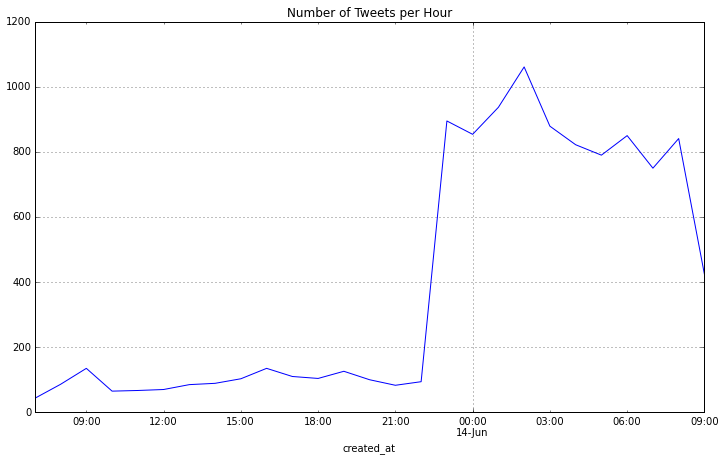

In [14]:
query = {}  # empty query means find all documents

# return just two columns, the date of creation and the id of each document
projection = {'created_at': 1}

df = pd.DataFrame(list(COLL.find(query, projection)))
times = pd.to_datetime(df.created_at)
df.set_index(times, inplace=True)
df.drop('created_at', axis=1, inplace=True)
tweets_all = df.resample('60Min', how='count')

tweets_all.plot(figsize=[12, 7], title='Number of Tweets per Hour', legend=None);

## More Complex Query

As an example of a more complex query, the following demonstrates how to extract all tweets that are not retweets, contain the hashtag `#happy` as well at least one other hashtag, and that are written in English. These attributes are passed to the `.find` method as a dictionary, and the hashtags are then extracted.

The hashtags of the first ten tweets meeting this specification are then printed out.

In [15]:
query = {                                # find all documents that: 
        'hashtags': {'$in': ['happy']},  # contain #happy hashtag
        'retweeted_status': None,        # are not retweets
        'hashtags.1': {'$exists': True}, # and have more than 1 hashtag
        'lang': 'en'                     # written in English
        }
projection = {'hashtags': 1, '_id': 0}
cursor = COLL.find(query, projection)

for tags in cursor[:10]:
    print tags['hashtags']

[u'rains', u'drenched', u'happy', u'kids', u'birds', u'animals', u'tatasky', u'home', u'sad', u'life']
[u'quote', u'wisdom', u'sad', u'happy']
[u'truro', u'nightout', u'drunk', u'nationalginday', u'happy', u'fun', u'cornwall', u'girlsnight', u'zafiros']
[u'happy', u'positivity']
[u'vaghar', u'cook', u'ghee', u'colzaoil', u'spices', u'love', u'happy', u'digestion', u'ayurveda', u'intuitive']
[u'happy', u'yay']
[u'kinderscout', u'peakdistrict', u'darkpeaks', u'happy']
[u'ichoisehappy', u'life', u'happy', u'quote', u'instaphoto']
[u'streetartthrowdown', u'me', u'myself', u'wacky', u'pretty', u'cute', u'nice', u'awesome', u'cool', u'smile', u'happy', u'selfie', u'selca']
[u'brothers', u'love', u'forever', u'heart', u'bless', u'live', u'family', u'happy', u'proud']


## Build a Network of Hashtags

We could use this method to produce a network of hashtags. The following illustrates this by:

- creating a generator function that yields every possible combination of two hashtags from each tweet
- adding these pairs of tags as edges in a NetworkX graph
- deleting the node `happy` (since it is connected to all the others by definition)
- deleting those edges that are below a threshold weight
- plotting the result

In order to run this, we need to install the NetworkX package (`pip install networkx`, [documentation](https://networkx.github.io/documentation.html)) and import it as well as the `combinations` function from Python's standard library [`itertools` module](https://docs.python.org/2/library/itertools.html).

In [16]:
from itertools import combinations

import networkx as nx

### Generate list of all pairs of hashtags

In [17]:
def gen_edges(coll, hashtag):
    query = {                            # find all documents that: 
        'hashtags': {'$in': [hashtag]},  # contain hashtag of interest
        'retweeted_status': None,        # are not retweets
        'hashtags.1': {'$exists': True}, # and have more than 1 hashtag
        'lang': 'en'                     # written in English
        }
    projection = {'hashtags': 1, '_id': 0}
    cursor = coll.find(query, projection)
    
    for tags in cursor:
        hashtags = tags['hashtags']
        for edge in combinations(hashtags, 2):
            yield edge

### Build graph with weighted edges between hashtags

In [18]:
G = nx.Graph()
for u,v in gen_edges(COLL, 'happy'):
    if G.has_edge(u,v):
        # add 1 to weight attribute of this edge
        G[u][v]['weight'] = G[u][v]['weight'] + 1
    else:
        # create new edge of weight 1
        G.add_edge(u, v, weight=1)

print len(G.edges())

24545


Since the node `happy` is connected to every other node, it does not add any meaning. Let's remove it and see how many edges we have left:

In [19]:
G.remove_node('happy')
print len(G.edges())

20242


### Remove rarer edges

Finally we remove rare edges (defined here arbitrarily as edges that have a weigthing of less than 25), then print a table of these edges sorted in descending order by weight.

In [20]:
def trim_edges(g, weight=1):
    # function from http://shop.oreilly.com/product/0636920020424.do
    g2 = nx.Graph()
    for u, v, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(u, v, edata)
    return g2

### View as Table

In [21]:
G2 = trim_edges(G, weight=25)

df = pd.DataFrame([(u, v, edata['weight'])
                   for u, v, edata in G2.edges(data=True)],
                  columns = ['from', 'to', 'weight'])
df.sort(['weight'], ascending=False, inplace=True)
df

,from,to,weight
7,love,me,78
1,cute,love,74
14,love,follow,74
11,love,instagood,72
17,love,photooftheday,64
48,me,instagood,63
43,photooftheday,instagood,63
31,follow,instagood,63
4,cute,follow,63
0,cute,me,62


### Plot the Network

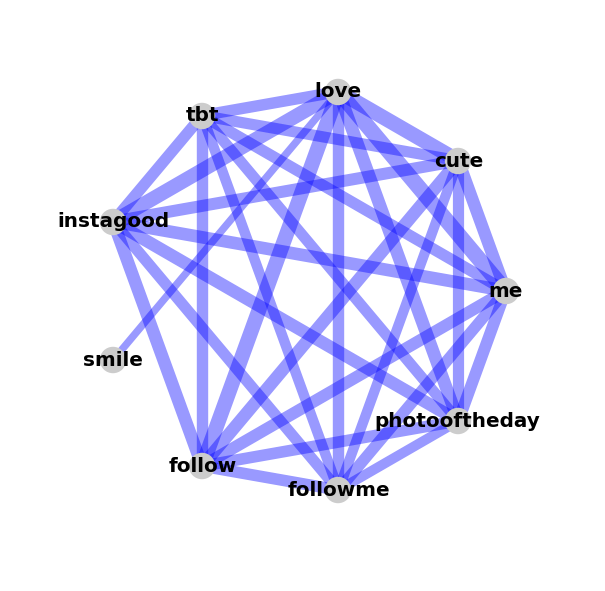

In [22]:
G3 = trim_edges(G, weight=35)

pos=nx.circular_layout(G3) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G3, pos, node_size=700,
                       linewidths=0, node_color='#cccccc')

edge_list = [(u, v) for u, v in G3.edges()]
weight_list = [edata['weight']/5.0 for u, v, edata in G3.edges(data=True)]

# edges
nx.draw_networkx_edges(G3, pos,
                       edgelist=edge_list,
                       width=weight_list,
                       alpha=0.4,edge_color='b')

# labels
nx.draw_networkx_labels(G3, pos, font_size=20,
                        font_family='sans-serif', font_weight='bold')

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.axis('off');